# NNX and NumPyro Integration

In this example notebook we illustrate how to incorporate neural network components from the [NNX](https://flax.readthedocs.io/en/v0.8.3/experimental/nnx/index.html) library into NumPyro models. In a similar way, you can use the [Flax Linen API](https://flax-linen.readthedocs.io/en/latest/).

This notebook is based on the blog post [Flax and NumPyro Toy Example](https://juanitorduz.github.io/flax_numpyro/).

## Prepare Notebook

In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz flax matplotlib

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

from flax import nnx
from jax import random
import jax.numpy as jnp

import numpyro
from numpyro.contrib.module import nnx_module, random_nnx_module
import numpyro.distributions as dist
from numpyro.handlers import condition
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import Predictive

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Data

We generate a synthetic dataset with non-linear mean and standard deviation.

In [3]:
n = 32 * 10
rng_key, rng_subkey = random.split(rng_key)
x = jnp.linspace(1, jnp.pi, n)
mu_true = jnp.sqrt(x + 0.5) * jnp.sin(9 * x)
sigma_true = 0.15 * x**2
rng_key, rng_subkey = random.split(rng_key)
y = mu_true + sigma_true * random.normal(rng_key, shape=(n,))

Let's visualize the resulting data set:

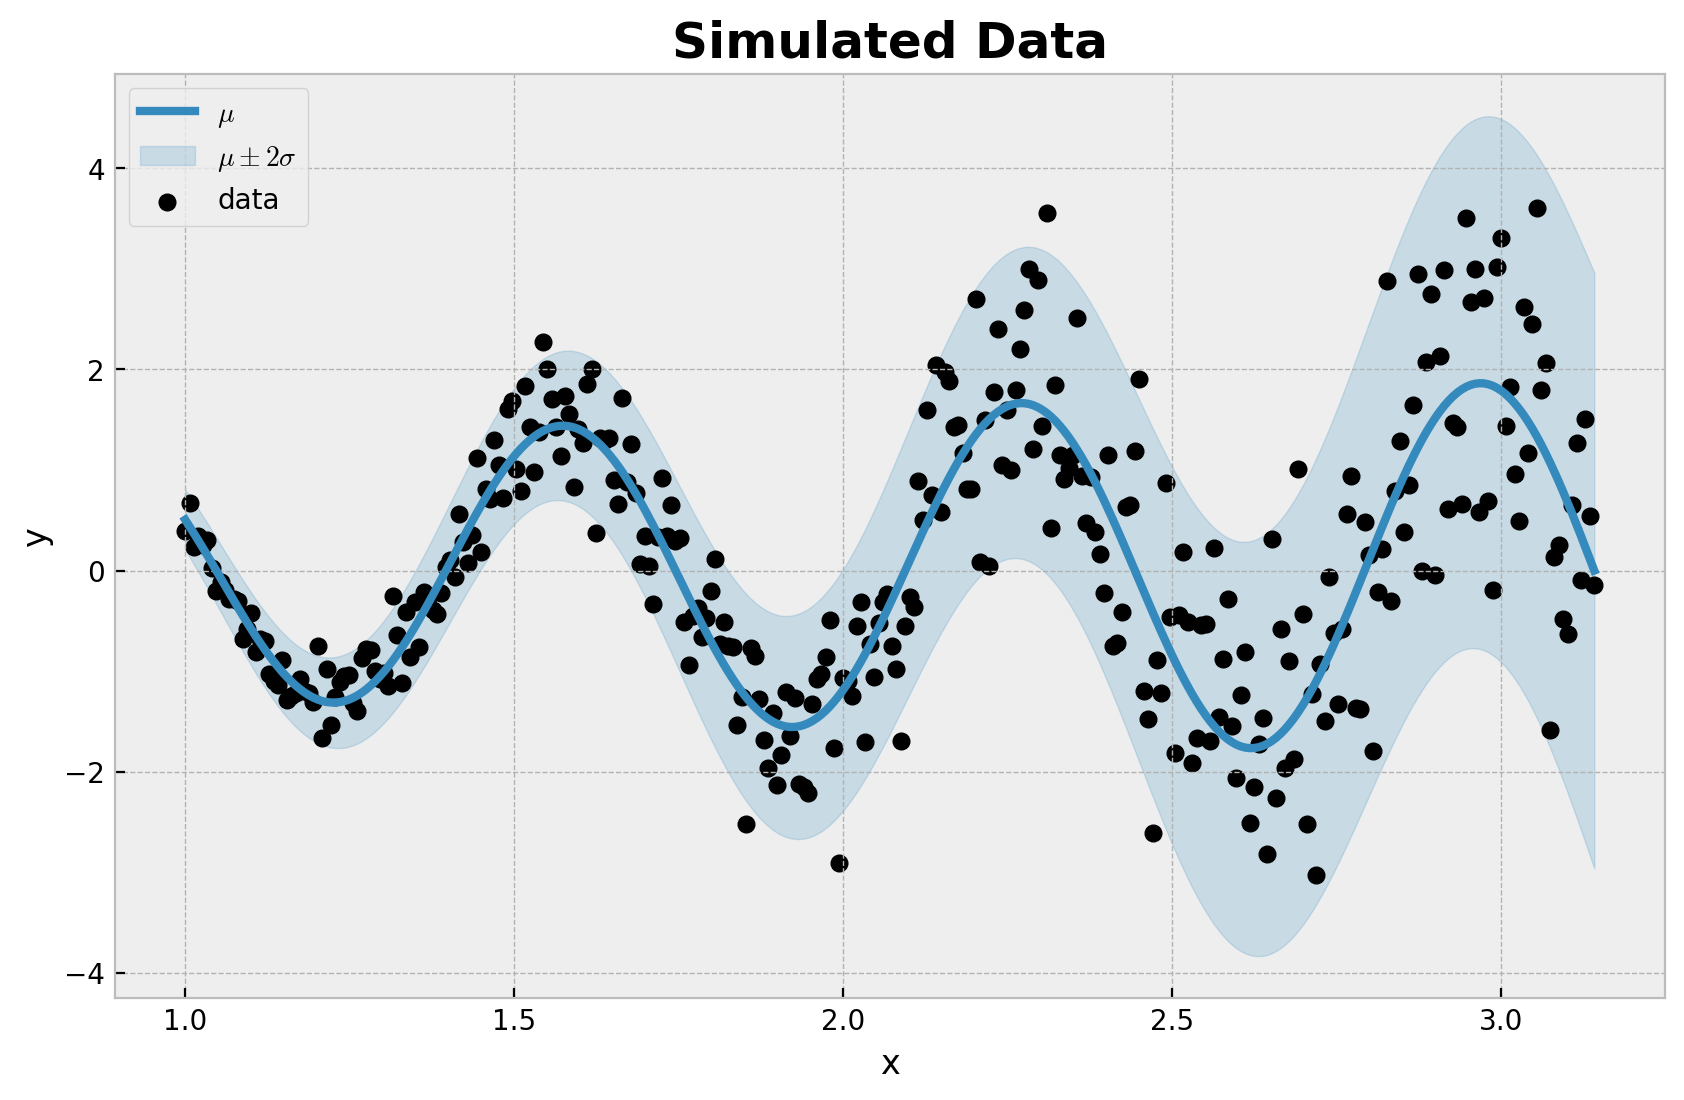

In [4]:
fig, ax = plt.subplots()
ax.plot(x, mu_true, color="C0", label=r"$\mu$", linewidth=3)
ax.fill_between(
    x,
    (mu_true - 2 * sigma_true),
    (mu_true + 2 * sigma_true),
    color="C0",
    alpha=0.2,
    label=r"$\mu \pm 2 \sigma$",
)
ax.scatter(x, y, color="black", label="data")
ax.legend(loc="upper left")
ax.set_title(label="Simulated Data", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y");

We clearly see that the data is non-linear and has heteroskedastic noise. We would like to model the mean and standard deviation of the data as a function of the input $x$ using neural networks to model the non-linearities.

## Model Specification

First, we prepare the data for training.

In [5]:
x_train = x[..., None]
y_train = y

Next, we use `NNX` to define two MLP components, one for the mean and one for the standard deviation. You can look into the [`NNX` basics](https://flax.readthedocs.io/en/v0.8.3/experimental/nnx/nnx_basics.html) for more details.

In [6]:
class LocMLP(nnx.Module):
    """3-layer Multi-layer perceptron for the mean."""

    def __init__(self, din: int, dmid: int, dout: int, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
        self.linear2 = nnx.Linear(dmid, dmid, rngs=rngs)
        self.linear3 = nnx.Linear(dmid, dout, rngs=rngs)

    def __call__(self, x, rngs=None):
        x = self.linear1(x)
        x = nnx.sigmoid(x)
        x = self.linear2(x)
        x = nnx.sigmoid(x)
        x = self.linear3(x)
        return x


class ScaleMLP(nnx.Module):
    """Single-layer MLP for the standard deviation."""

    def __init__(self, *, rngs: nnx.Rngs) -> None:
        self.linear = nnx.Linear(1, 1, rngs=rngs)

    def __call__(self, x, rngs=None):
        x = self.linear(x)
        return nnx.softplus(x)

We now define the the neural networks components in an "eager" way.

In [7]:
mu_nn_module = LocMLP(din=1, dmid=8, dout=1, rngs=nnx.Rngs(0))

sigma_nn_module = ScaleMLP(rngs=nnx.Rngs(1))

Finally, we  can add the neural networks components to the NumPyro model where we use a Normal distribution for the likelihood and allow the parameters vary over the input $x$.

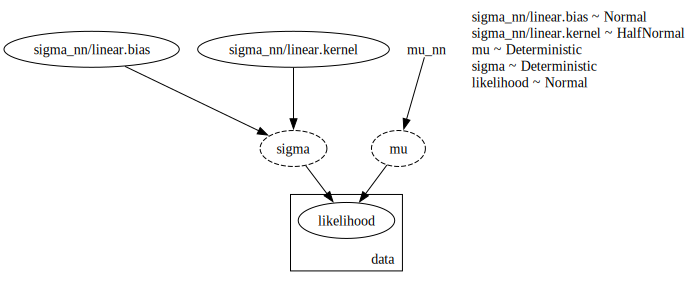

In [8]:
def model(x):
    # Neural network component for the mean. Here we consider the parameters of the
    # neural network as learnable.
    mu_nn = nnx_module("mu_nn", mu_nn_module)
    # Here we consider the parameters of the neural network as random variables.
    # Hence we can set priors for them.
    sigma_nn = random_nnx_module(
        "sigma_nn",
        sigma_nn_module,
        prior={
            # From the data we know the variance is increasing over x.
            # Hence we use a HalfNormal distribution to model the kernel term.
            "linear.kernel": dist.HalfNormal(scale=1),
            # We use a Normal distribution for the bias.
            "linear.bias": dist.Normal(loc=0, scale=1),
        },
    )

    mu = numpyro.deterministic("mu", mu_nn(x).squeeze())

    sigma = numpyro.deterministic("sigma", sigma_nn(x).squeeze())

    with numpyro.plate("data", len(x)):
        numpyro.sample("likelihood", dist.Normal(loc=mu, scale=sigma))


numpyro.render_model(
    model=model,
    model_args=(x_train,),
    render_distributions=True,
    render_params=True,
)

### Prior Predictive Checks

Before we perform inference, we can check the prior predictive distribution. To ensure the priors are meaningful.

In [9]:
prior_predictive = Predictive(model=model, num_samples=100)
rng_key, rng_subkey = random.split(key=rng_key)
prior_predictive_samples = prior_predictive(rng_subkey, x_train)

obs_train = jnp.arange(x_train.size)

idata = az.from_dict(
    prior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in prior_predictive_samples.items()
    },
    coords={"obs": obs_train},
    dims={"mu": ["obs"], "sigma": ["obs"], "likelihood": ["obs"]},
)

First, we visualize the prior predictive distribution. We clearly wee that the variance is increasing over $x$ as we expected (as defined by the prior).
We also see that the range of the samples are withing a reasonable range from the data.  

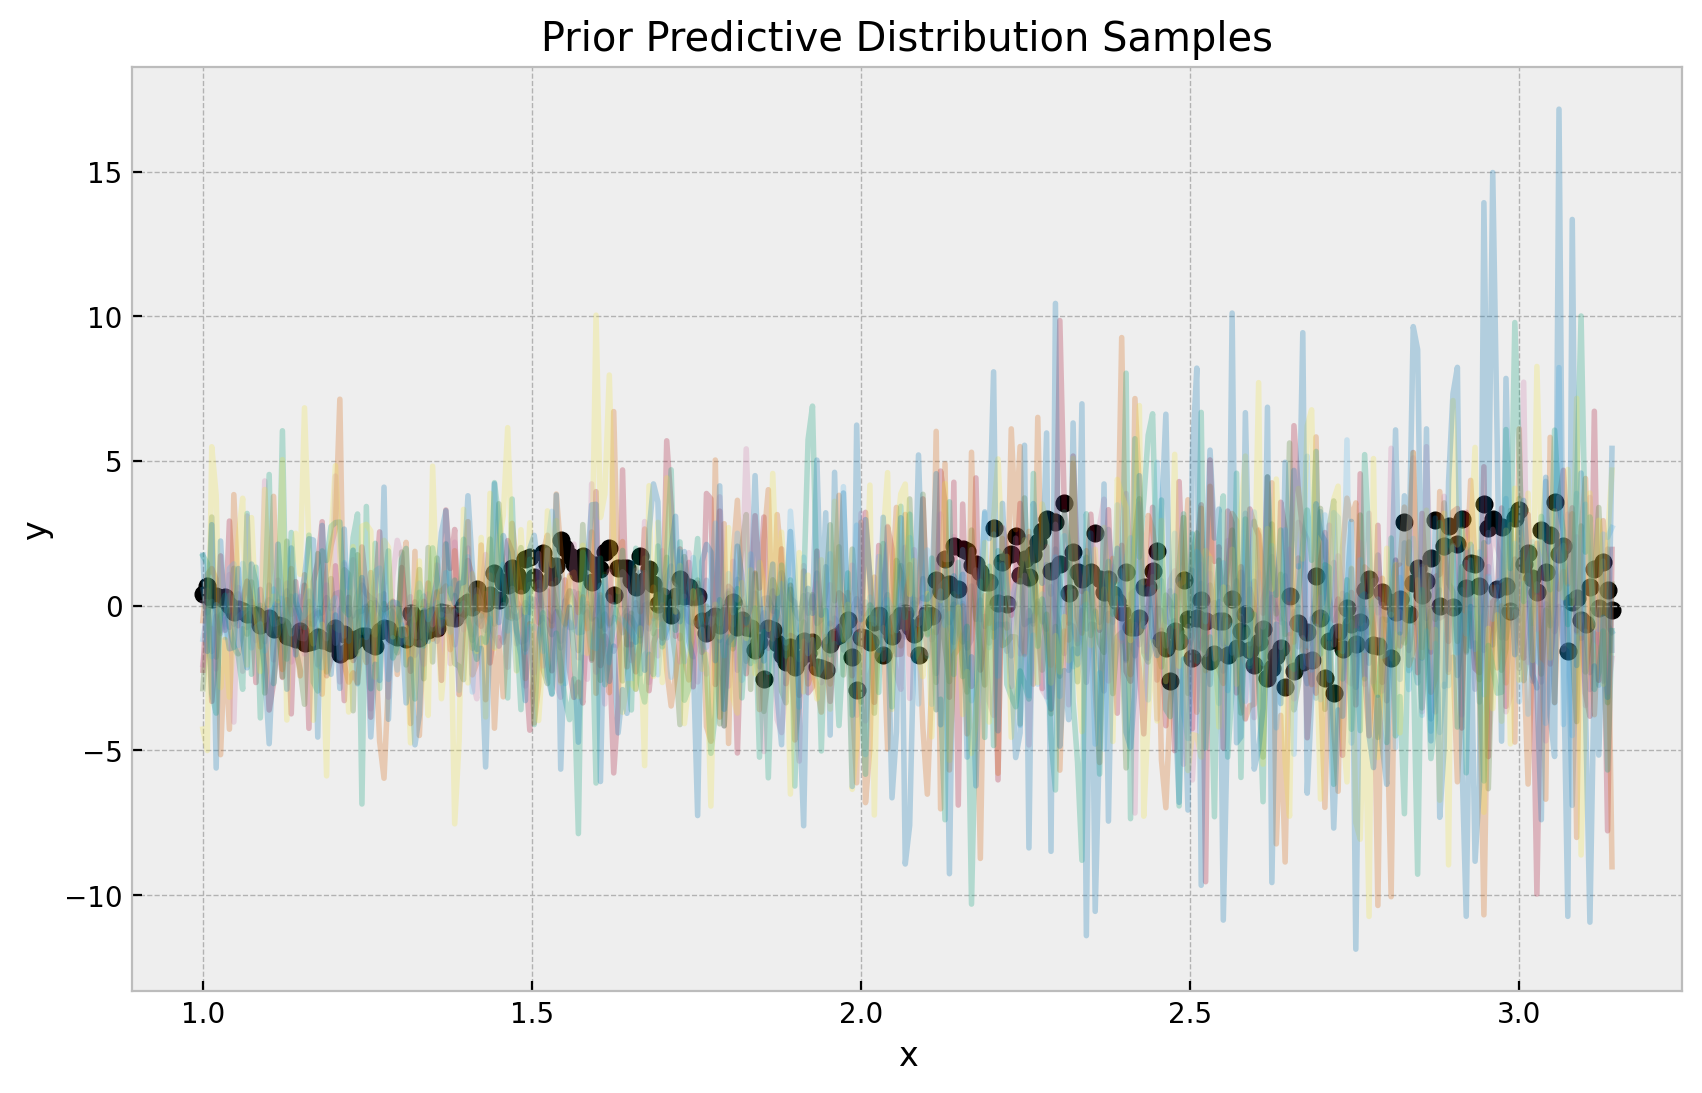

In [10]:
fig, ax = plt.subplots()

for i in range(10):
    ax.plot(x, idata["prior_predictive"]["likelihood"].sel(chain=0, draw=i), alpha=0.25)
ax.scatter(x, y, color="black", label="data")
ax.set(xlabel="x", ylabel="y", title="Prior Predictive Distribution Samples");

We can also verify the prior for the sigma kernel is working as expected:

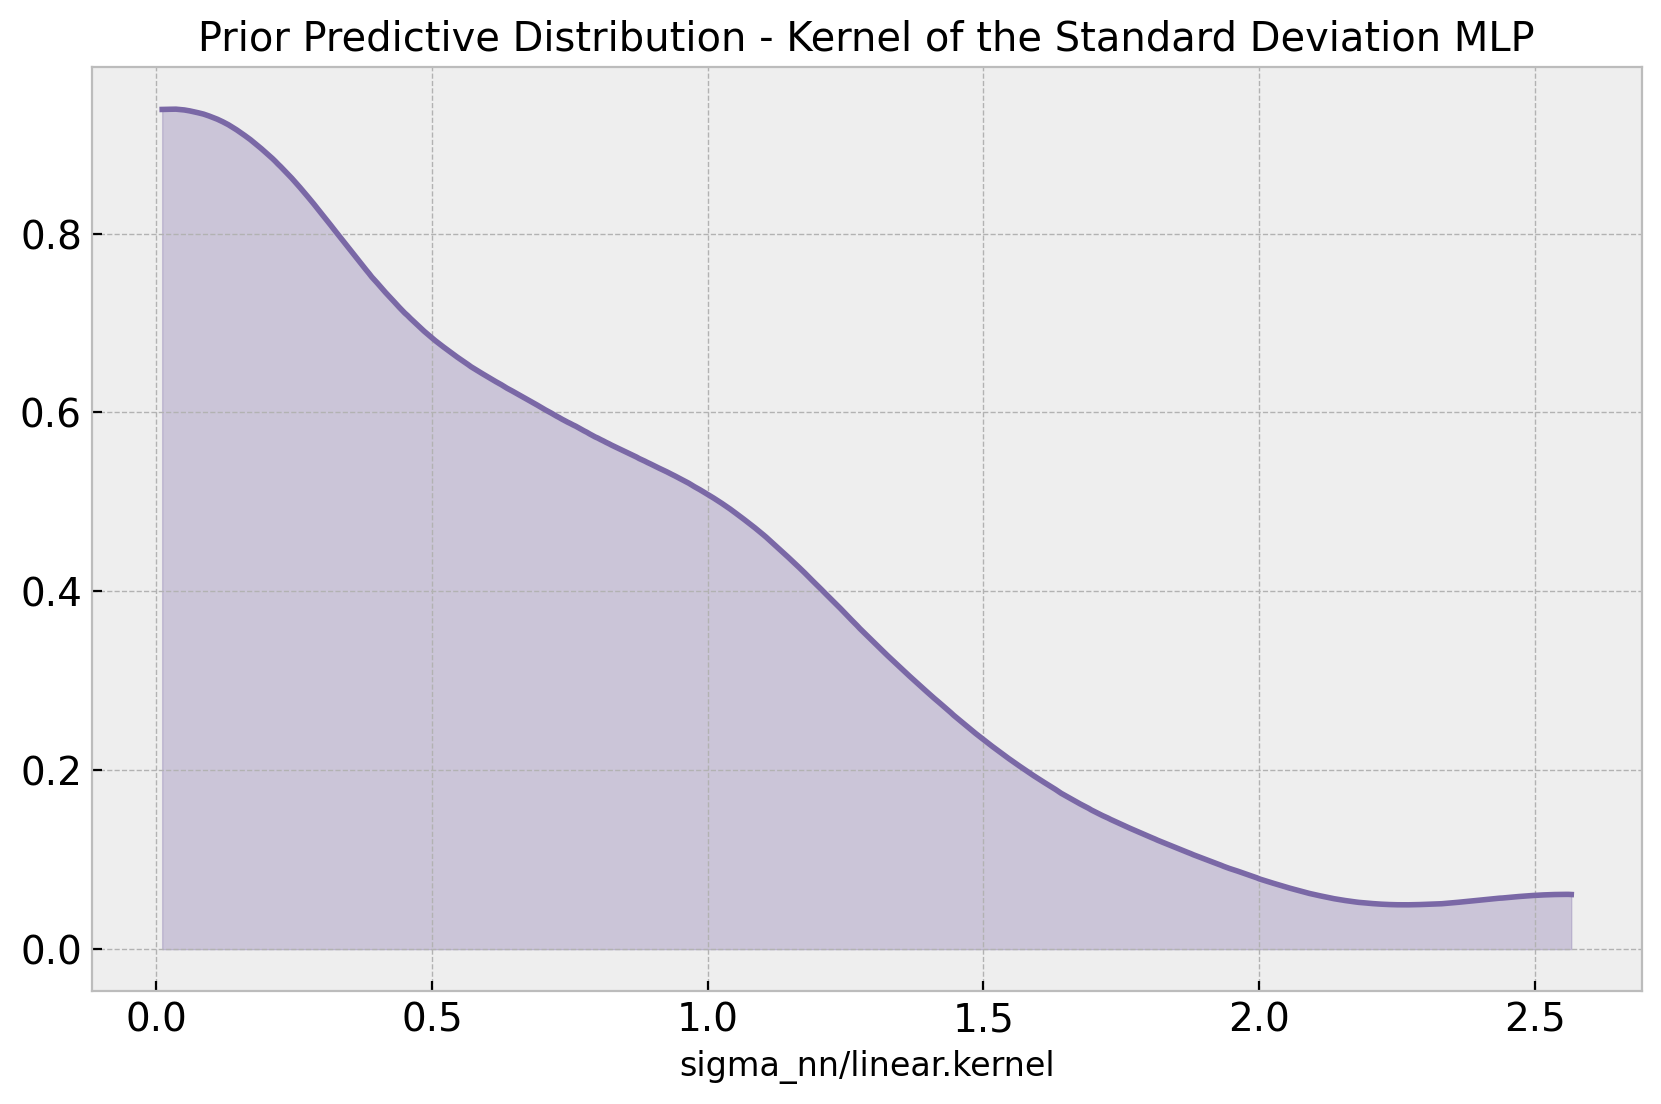

In [11]:
fig, ax = plt.subplots()

az.plot_dist(
    idata["prior_predictive"]["sigma_nn/linear.kernel"].squeeze(axis=(-1, -2)),
    color="C2",
    fill_kwargs={"alpha": 0.3},
)

ax.set(
    xlabel="sigma_nn/linear.kernel",
    title="Prior Predictive Distribution - Kernel of the Standard Deviation MLP",
);

We do see the prior is positive!

## Model Inference

We now perform inference on the model using SVI.

100%|██████████| 8000/8000 [00:01<00:00, 5976.75it/s, init loss: 1032.5969, avg. loss [7601-8000]: 287.5595]


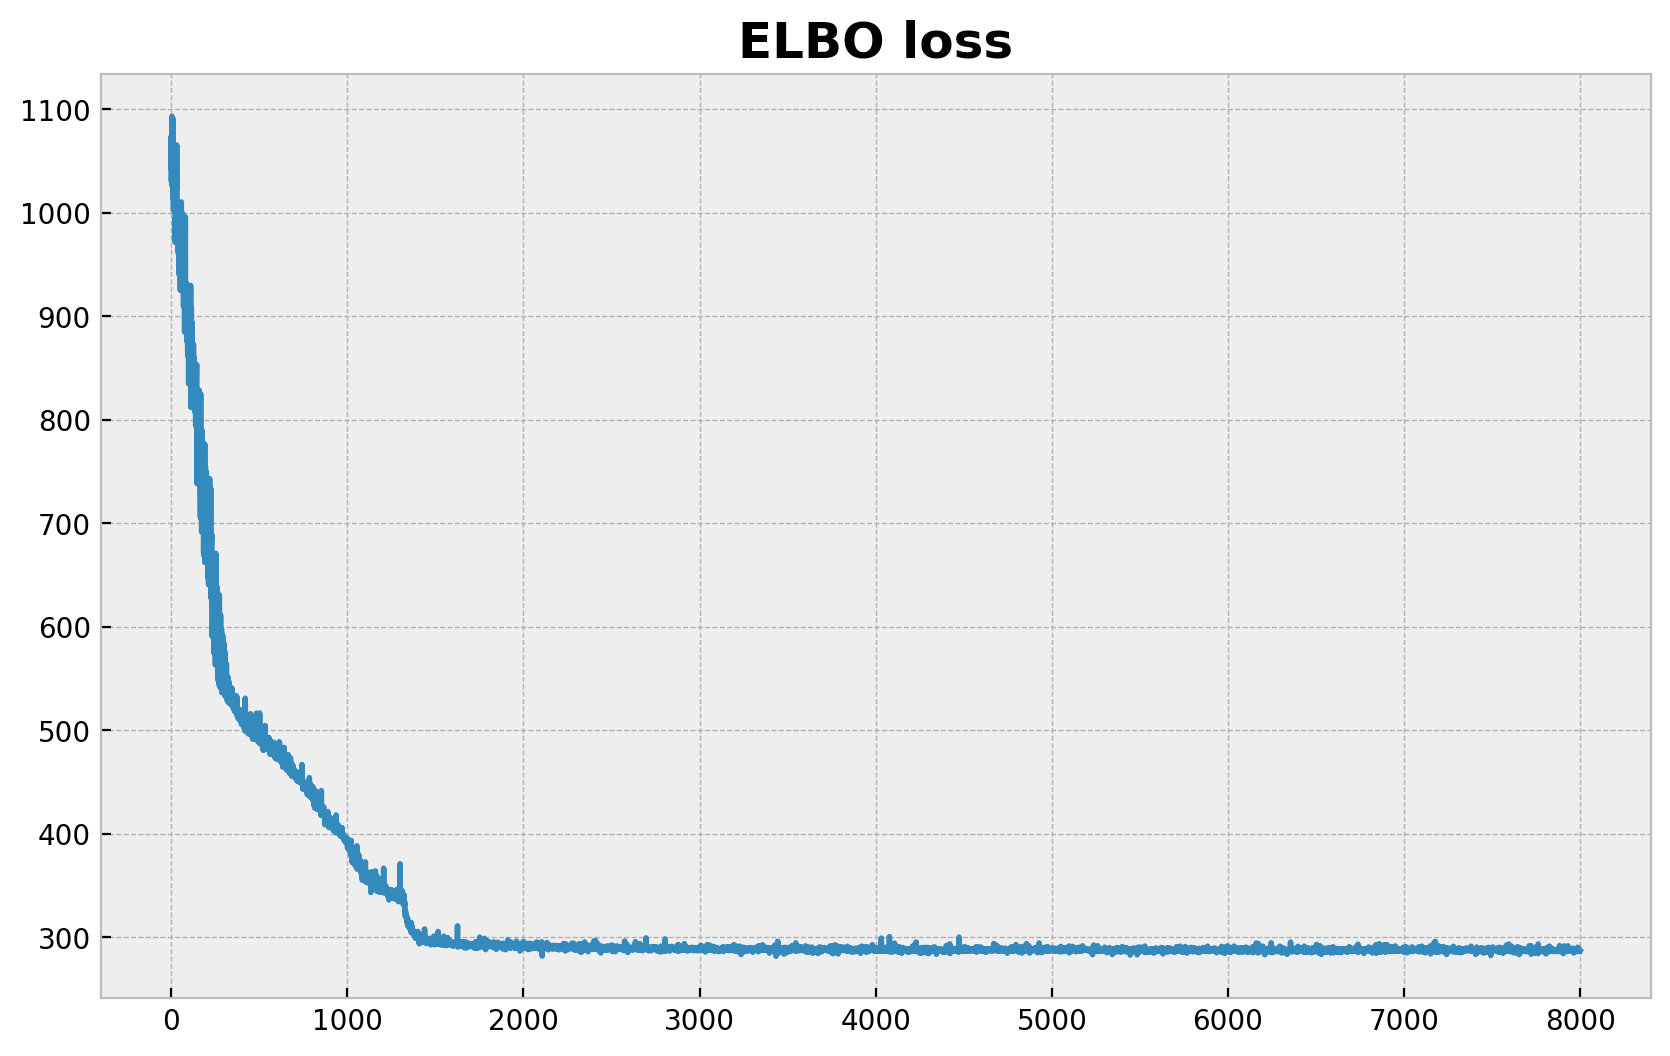

In [12]:
# We condition the model on the training data
conditioned_model = condition(model, data={"likelihood": y_train})

guide = AutoNormal(model=conditioned_model)
optimizer = numpyro.optim.Adam(step_size=0.005)
svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO())
n_samples = 8_000
rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(rng_subkey, n_samples, x_train)

fig, ax = plt.subplots()
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

We now generate the posterior predictive distribution.

In [13]:
params = svi_result.params
posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=params,
    num_samples=2_000,
    return_sites=["mu", "sigma", "likelihood"],
)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_predictive_samples = posterior_predictive(rng_subkey, x_train)

We now collect the posterior predictive samples for visualization purposes.

In [14]:
idata.extend(
    az.from_dict(
        posterior_predictive={
            k: np.expand_dims(a=np.asarray(v), axis=0)
            for k, v in posterior_predictive_samples.items()
        },
        coords={"obs": obs_train},
        dims={"mu": ["obs"], "sigma": ["obs"], "likelihood": ["obs"]},
    )
)

Finally, we visualize the posterior predictive distribution, the mean and the standard deviation components.

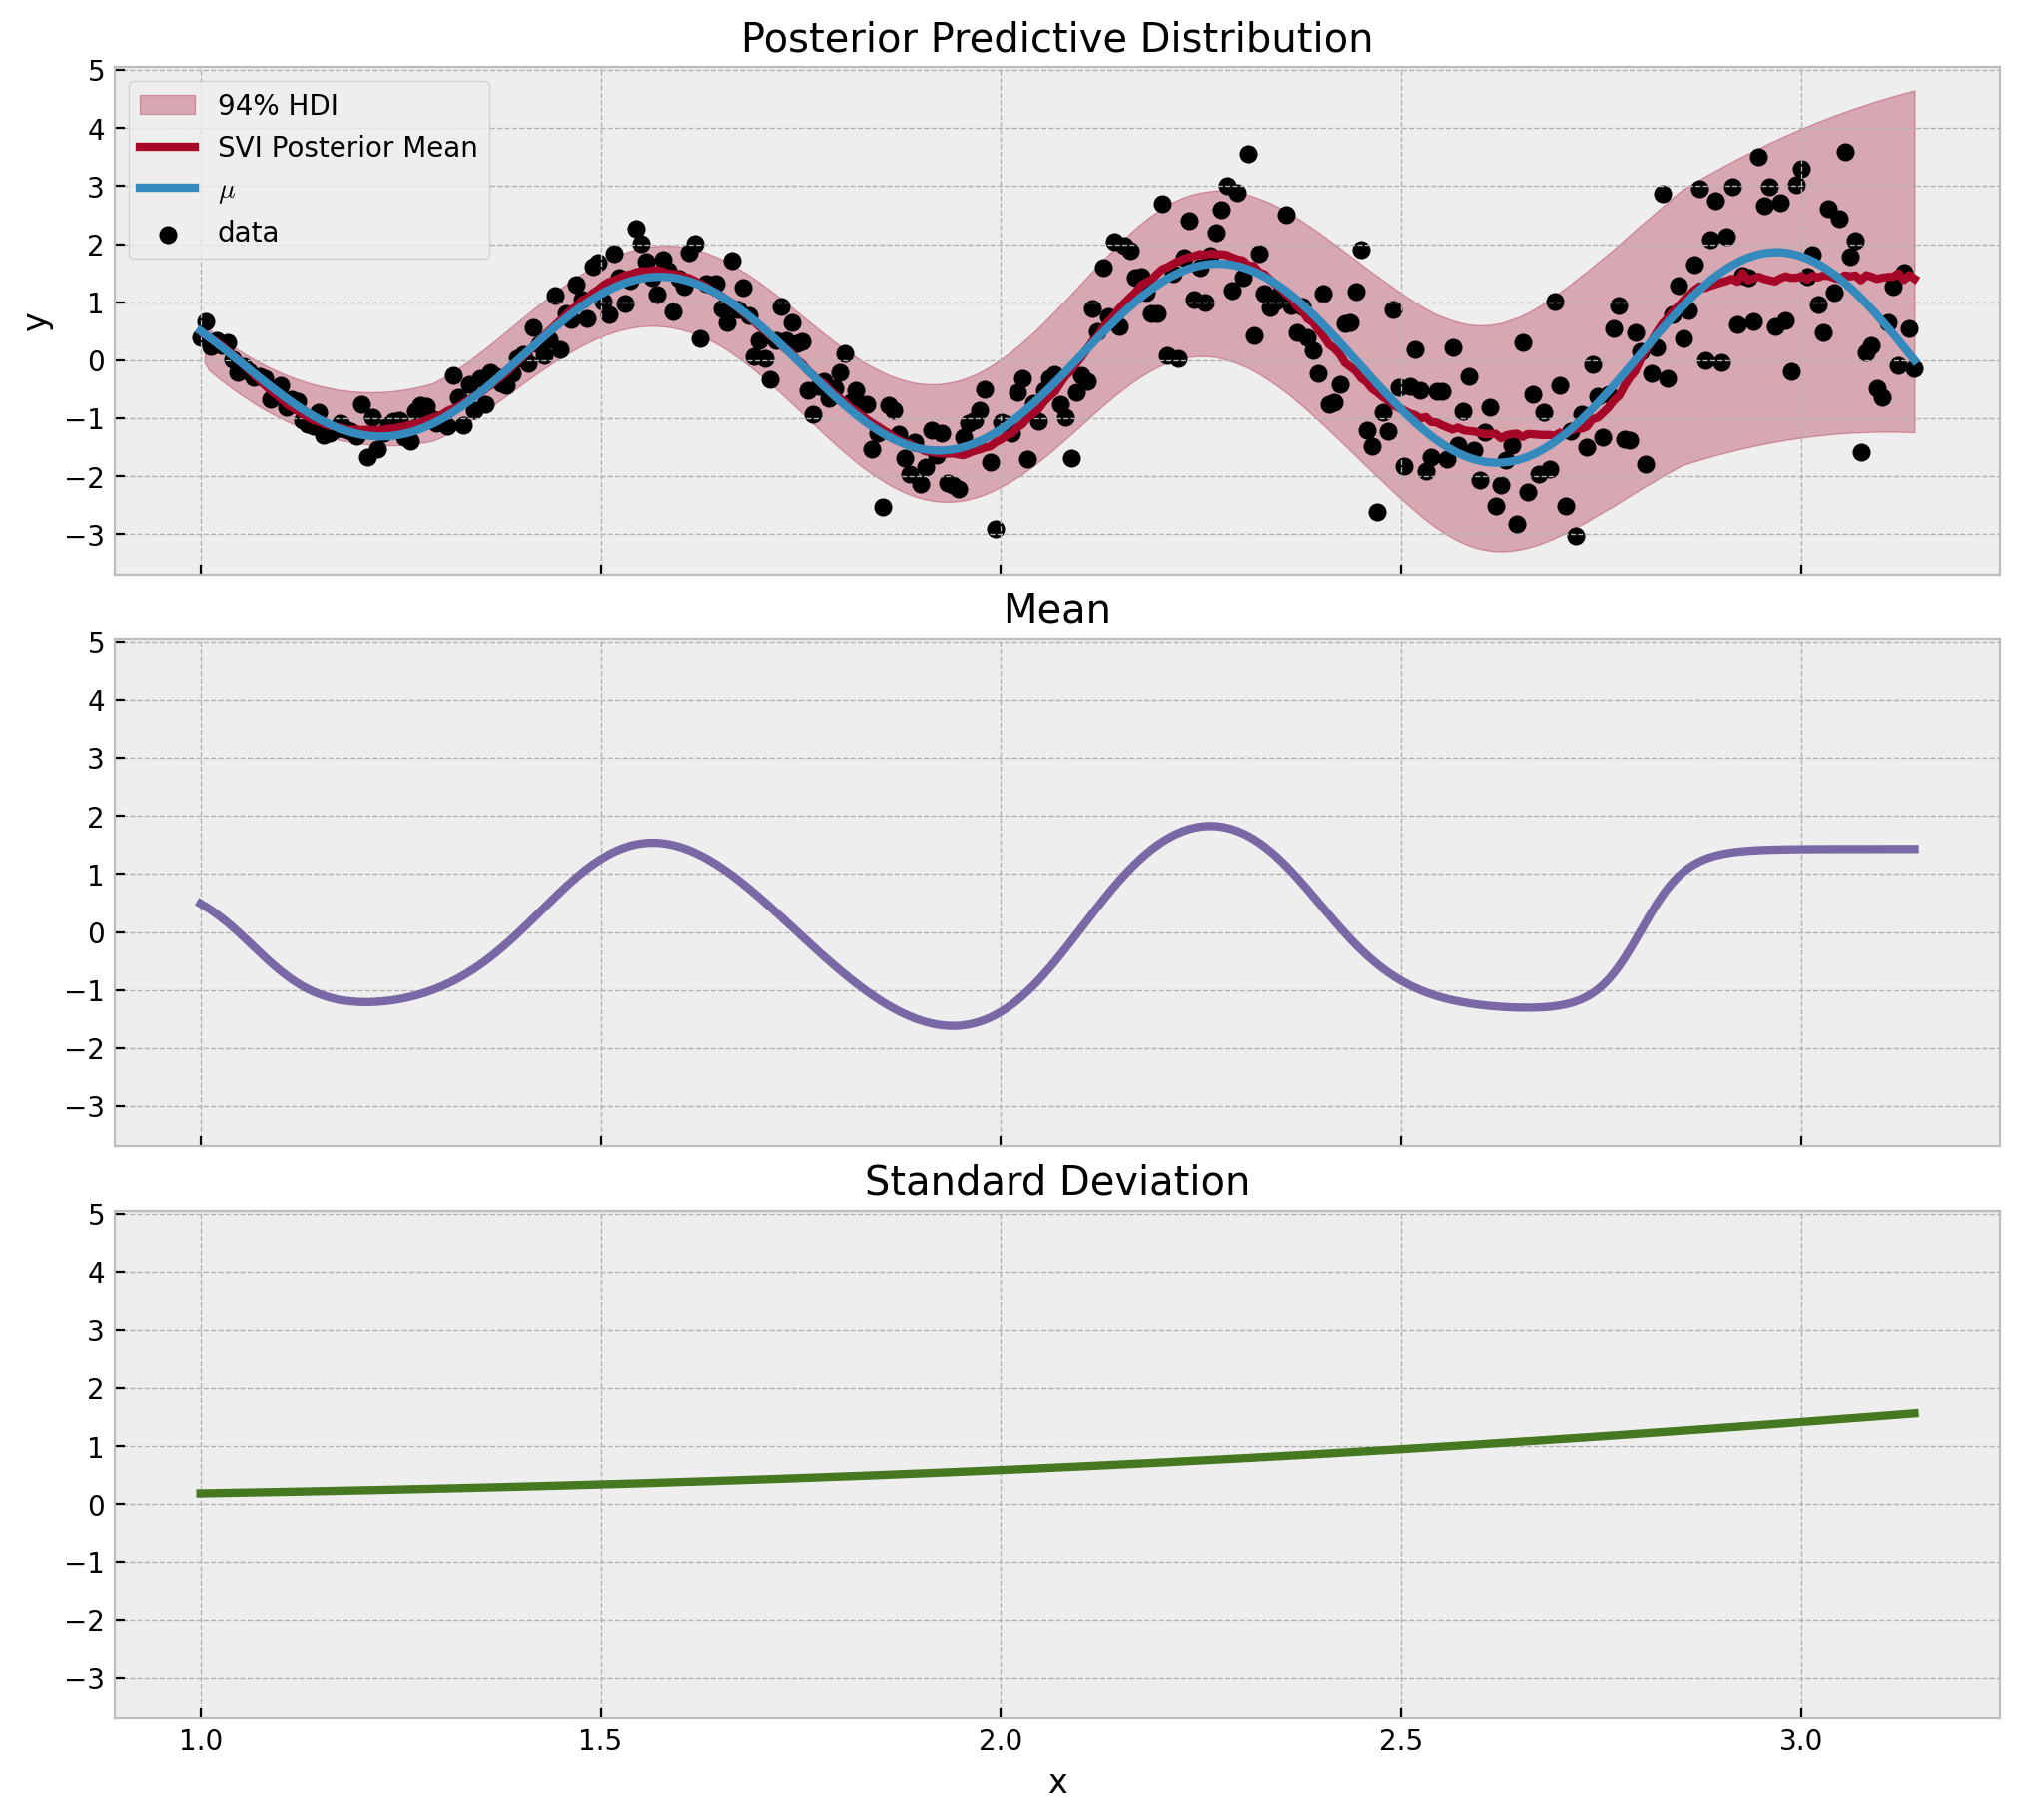

In [15]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=(10, 9),
    layout="constrained",
)

az.plot_hdi(
    x,
    idata["posterior_predictive"]["likelihood"],
    color="C1",
    fill_kwargs={"alpha": 0.3, "label": "94% HDI"},
    ax=ax[0],
)
ax[0].plot(
    x_train,
    idata["posterior_predictive"]["likelihood"].mean(dim=("chain", "draw")),
    color="C1",
    linewidth=3,
    label="SVI Posterior Mean",
)
ax[0].plot(x, mu_true, color="C0", label=r"$\mu$", linewidth=3)
ax[0].scatter(x, y, color="black", label="data")
ax[0].legend(loc="upper left")
ax[0].set(ylabel="y")
ax[0].set_title(label="Posterior Predictive Distribution")

ax[1].plot(
    x,
    idata["posterior_predictive"]["mu"].mean(dim=("chain", "draw")),
    linewidth=3,
    color="C2",
)
ax[1].set_title(label="Mean")

ax[2].plot(
    x,
    idata["posterior_predictive"]["sigma"].mean(dim=("chain", "draw")),
    linewidth=3,
    color="C3",
)
ax[2].set(xlabel="x")
ax[2].set_title(label="Standard Deviation");

The results look great! The fit and the components are working as expected.